In [15]:
import seaborn as sns
import pickle
from matplotlib import pyplot as plt
import numpy as np

def visualize(labels, values, key, xlabel, width=30):
    fig_dims = (width, 6)
    fig, ax = plt.subplots(figsize=fig_dims)
    ax.set(xlabel=xlabel, ylabel=key)
    values = np.array(values)
    order = np.argsort(values)
    ordered_values = values[order]
    ordered_labels = np.array(labels)[order]
    plt.xticks(rotation=270)
    ax = sns.barplot(x=ordered_labels, y=ordered_values, ax=ax)
    
def average(results, n_splits=3):
    return sum(results[n_splits:])/n_splits


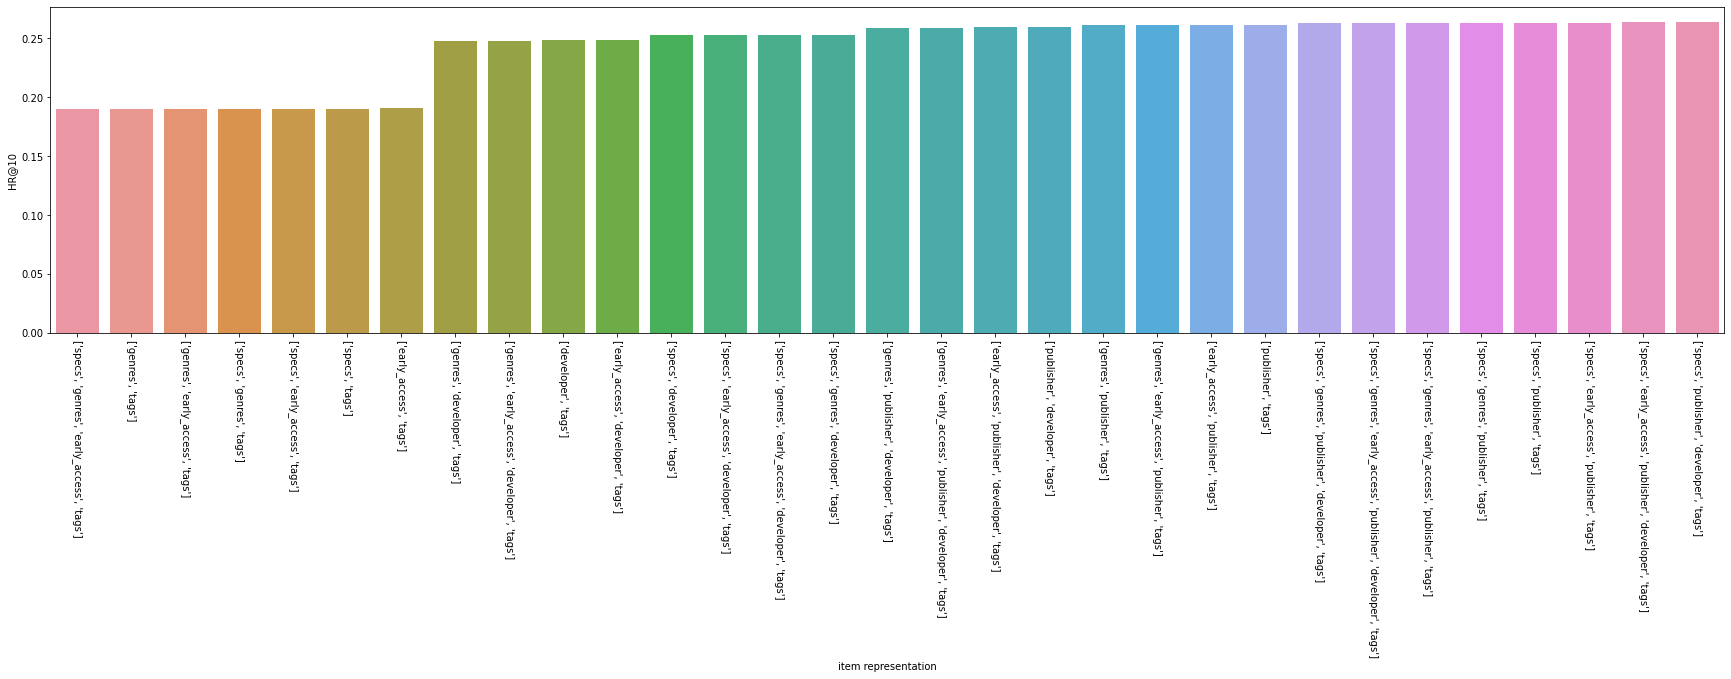

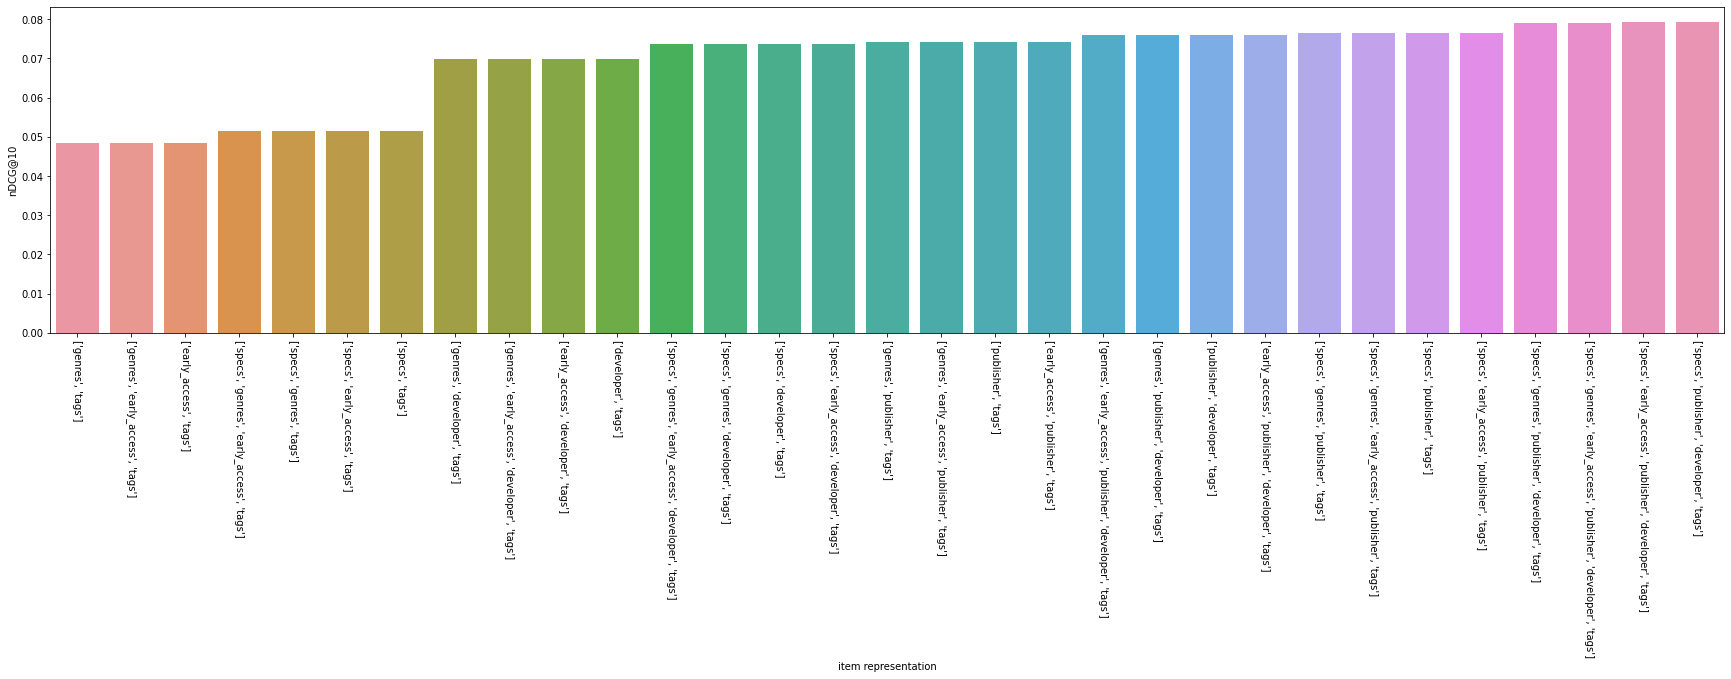

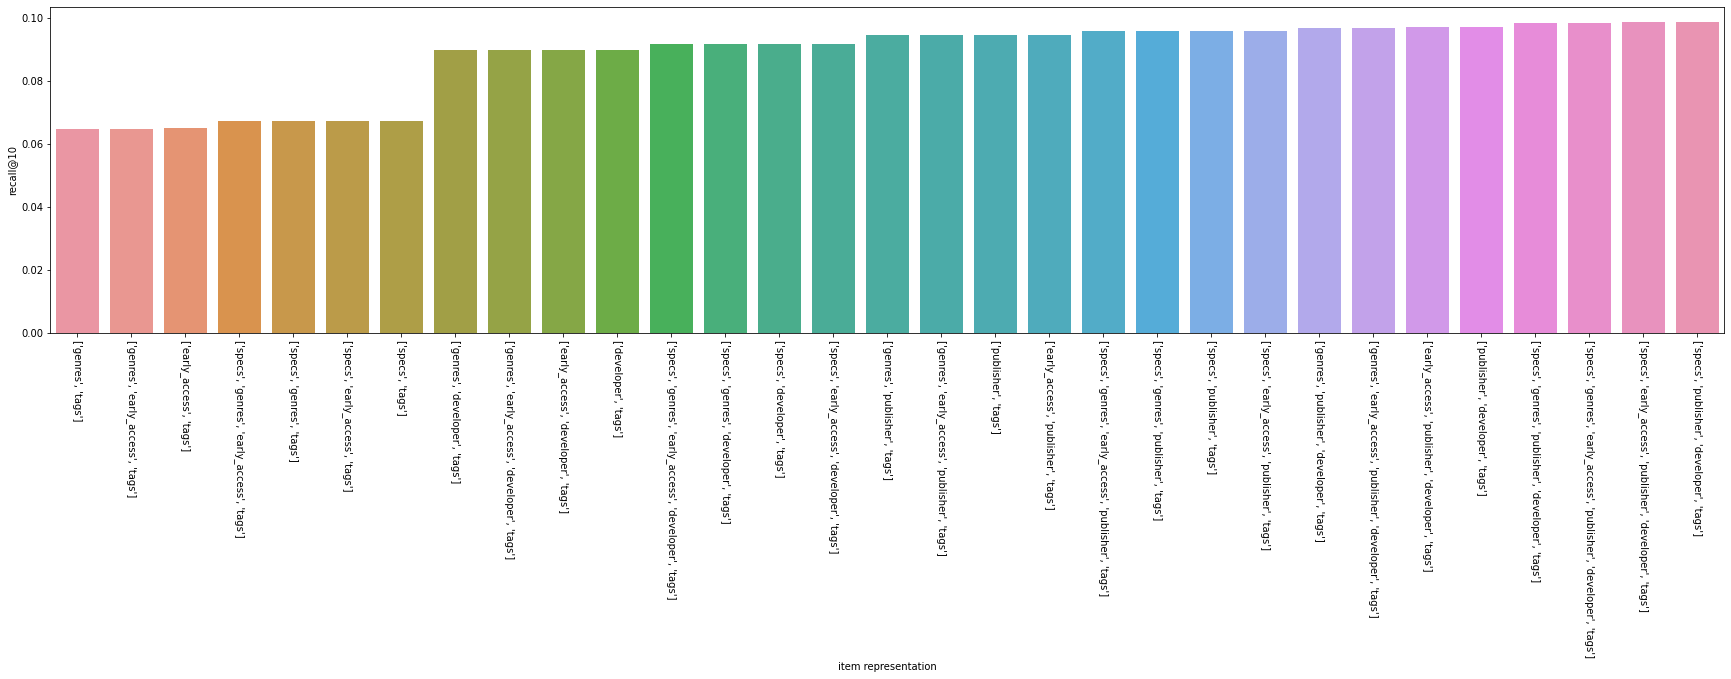

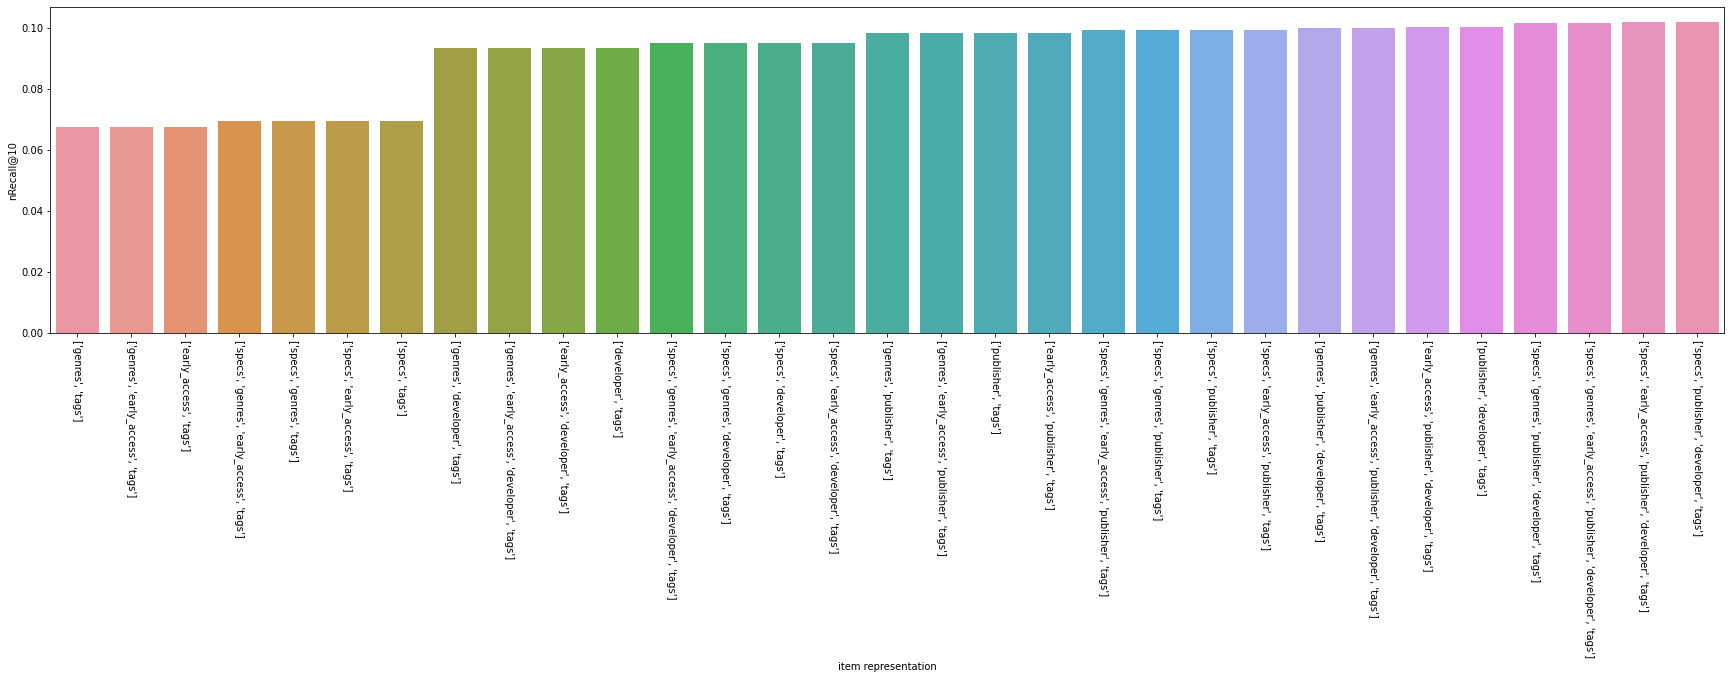

In [12]:
with open('./evaluation/representations.pickle', 'rb') as handle:
    labels = pickle.load(handle)
    
with open('./evaluation/representations_results.pickle', 'rb') as handle:
    results = pickle.load(handle)
    
labels = [str(label) for label in labels]
for key in results[0].keys():
    if key[-2:] == '10' and key[:-3] != 'ideal_recall':
        values = [result[key] for result in results]
        visualize(labels, values, key, 'item representation')

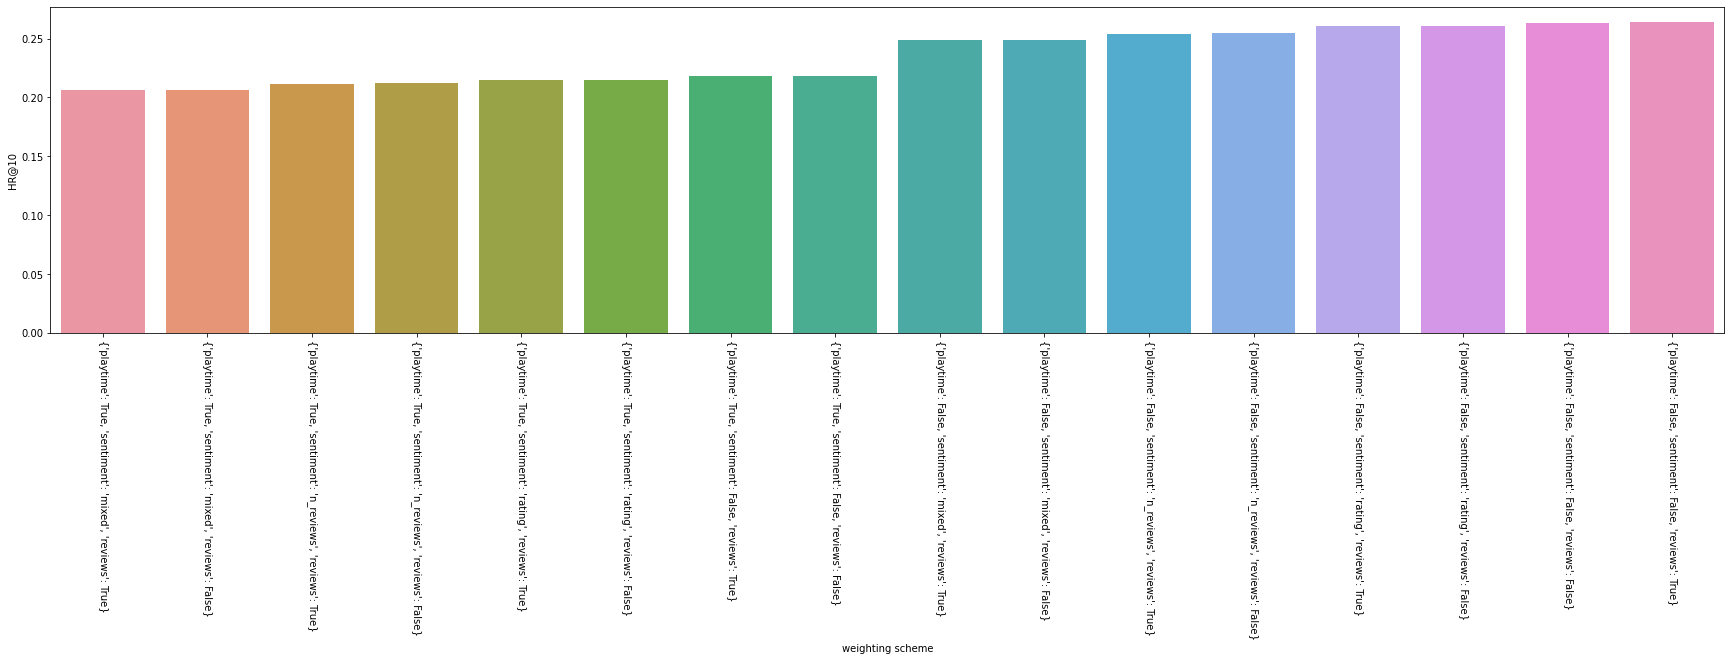

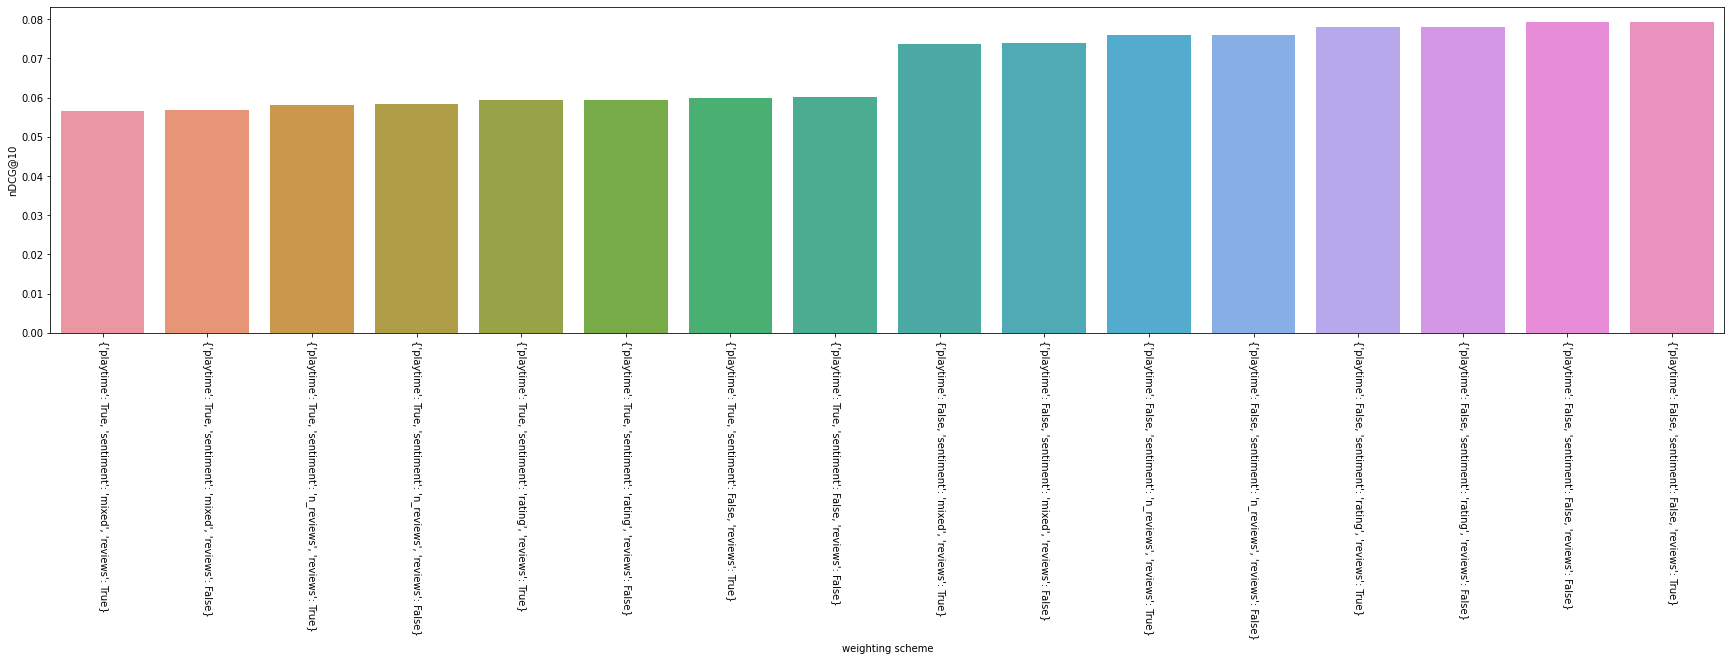

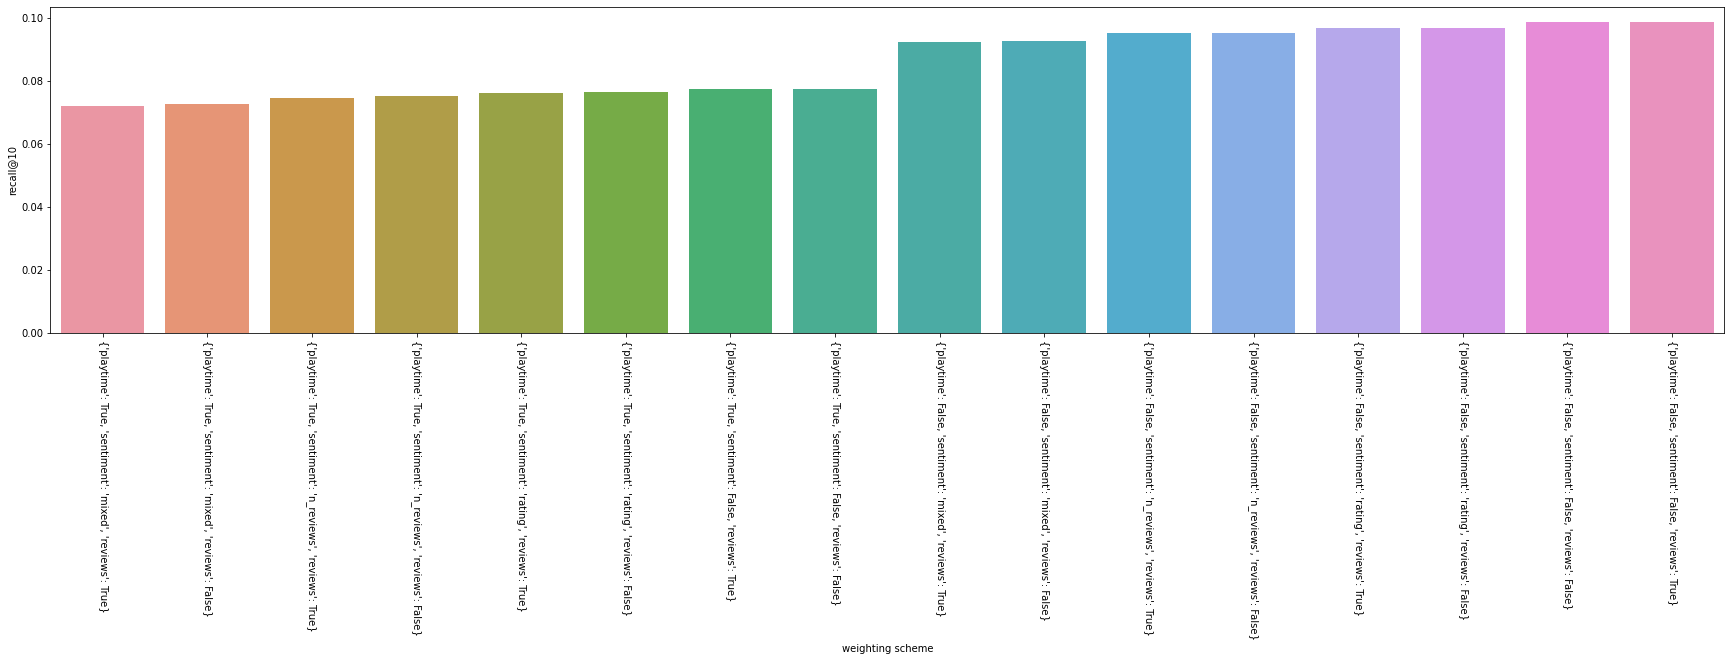

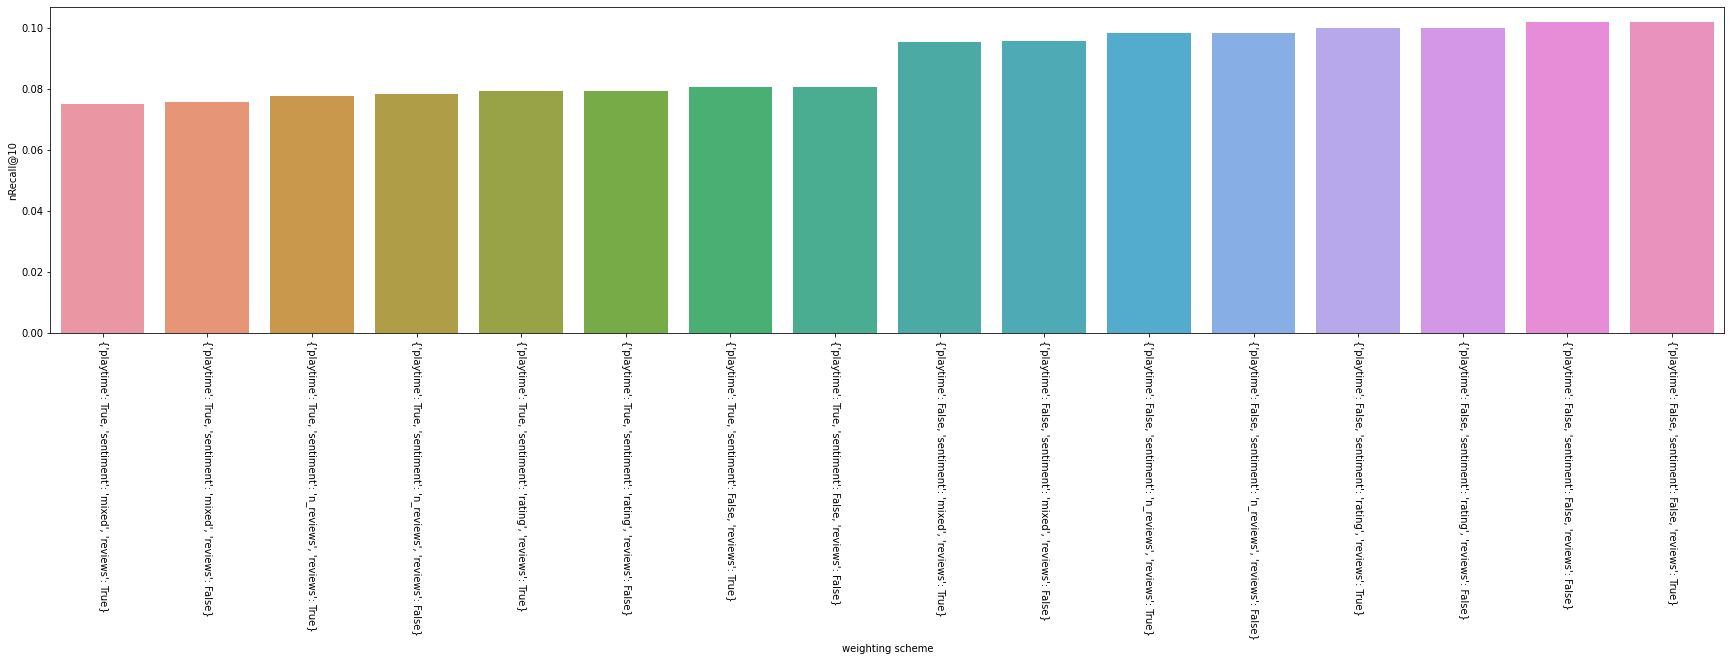

In [13]:
with open('./evaluation/weighting_schemes.pickle', 'rb') as handle:
    labels = pickle.load(handle)
    
with open('./evaluation/weighting_schemes_results.pickle', 'rb') as handle:
    results = pickle.load(handle)
    
labels = [str(label) for label in labels]
for key in results[0].keys():
    if key[-2:] == '10' and key[:-3] != 'ideal_recall':
        values = [result[key] for result in results]
        visualize(labels, values, key, 'weighting scheme')

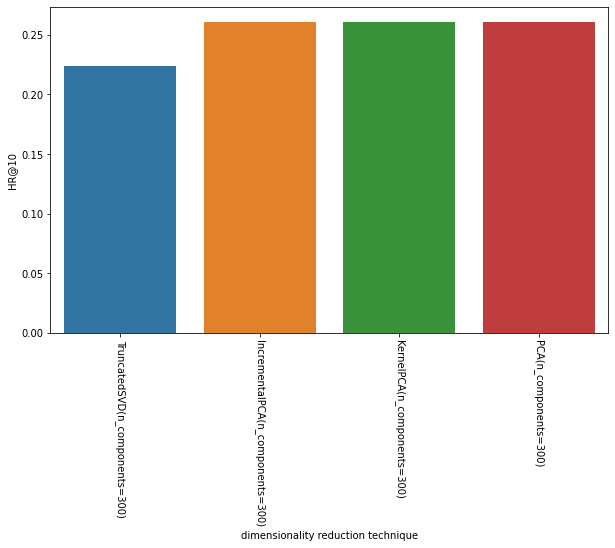

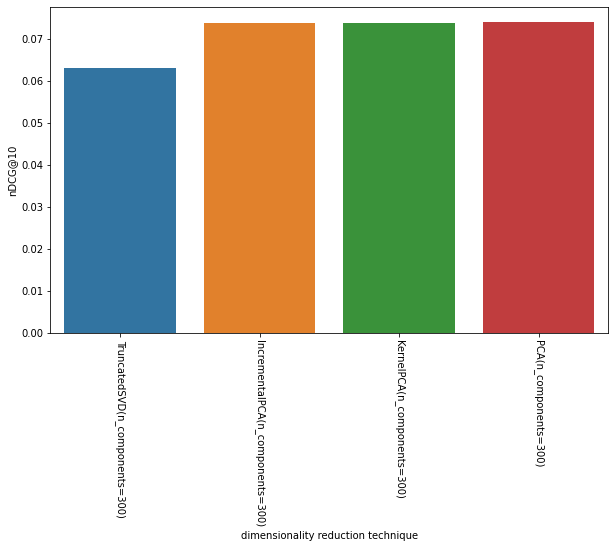

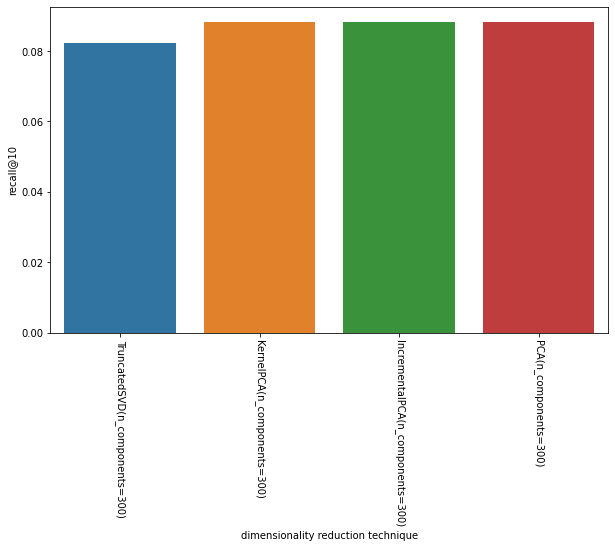

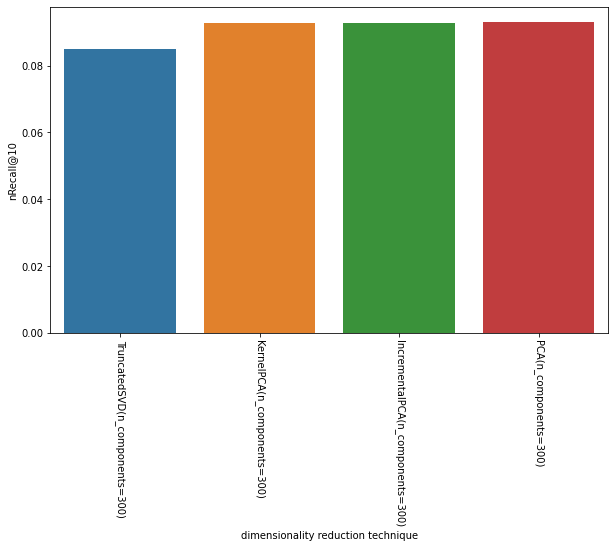

In [14]:
with open('./evaluation/dim_reduction.pickle', 'rb') as handle:
    labels = pickle.load(handle)
    
with open('./evaluation/dim_reduction_results.pickle', 'rb') as handle:
    results = pickle.load(handle)
    
labels = [str(label) for label in labels]
for key in results[0].keys():
    if key[-2:] == '10' and key[:-3] != 'ideal_recall':
        values = [result[key] for result in results]
        visualize(labels, values, key, 'dimensionality reduction technique', width=10)

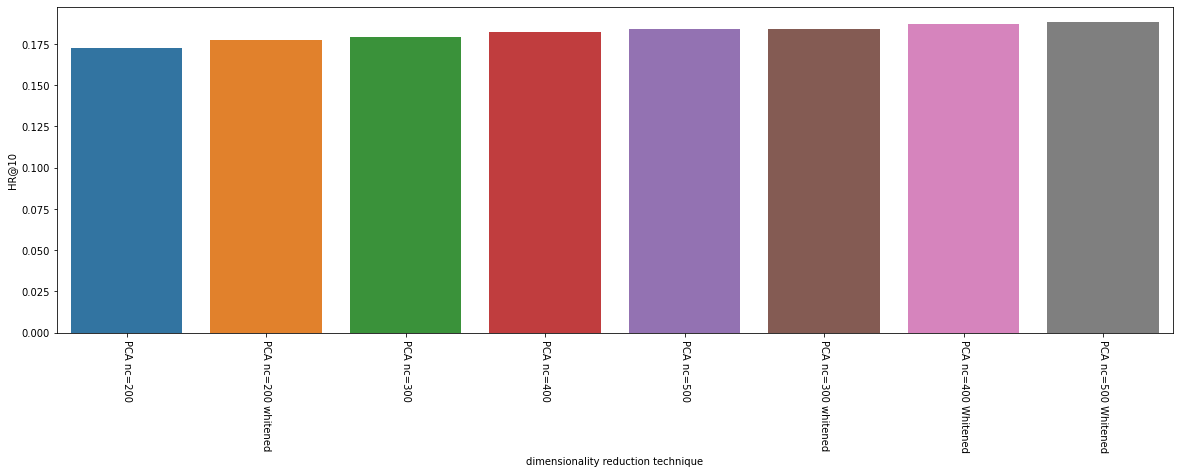

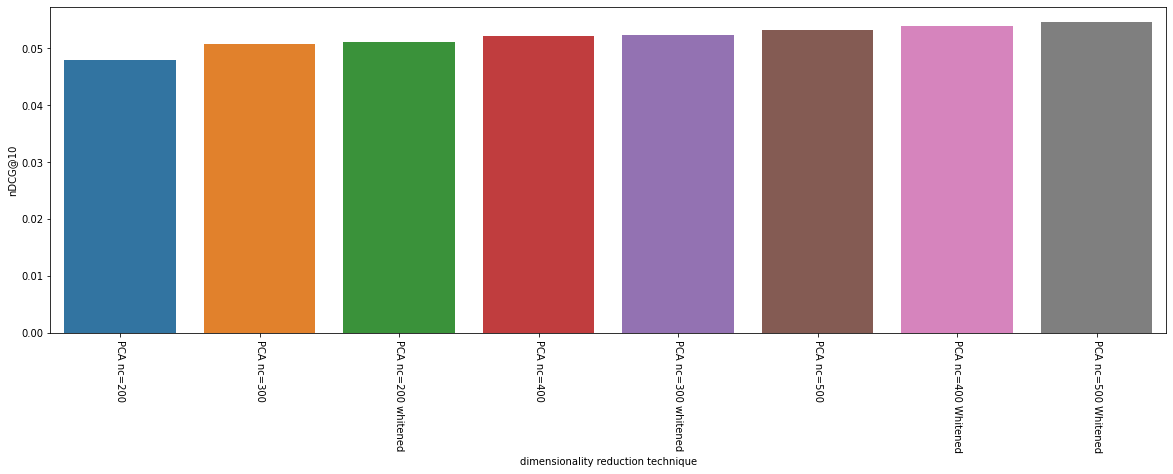

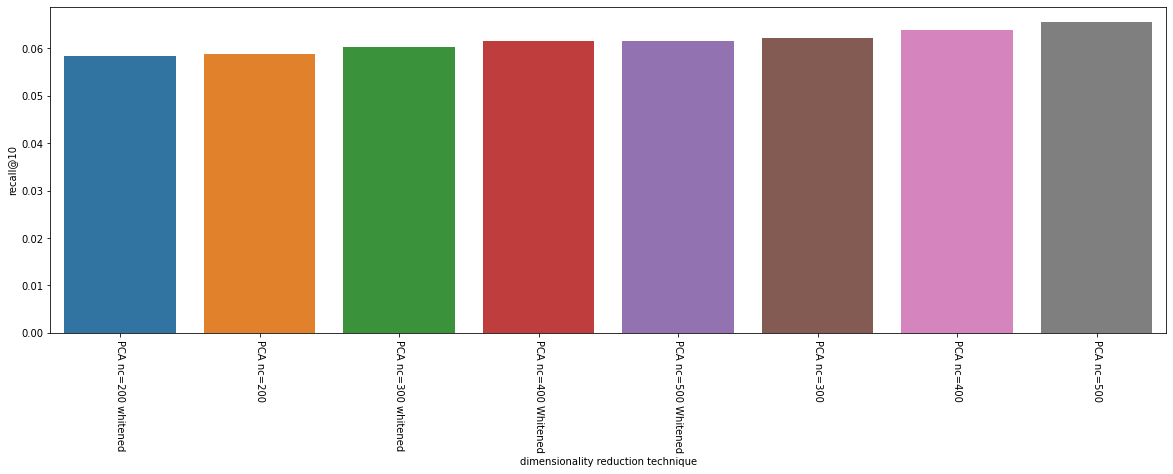

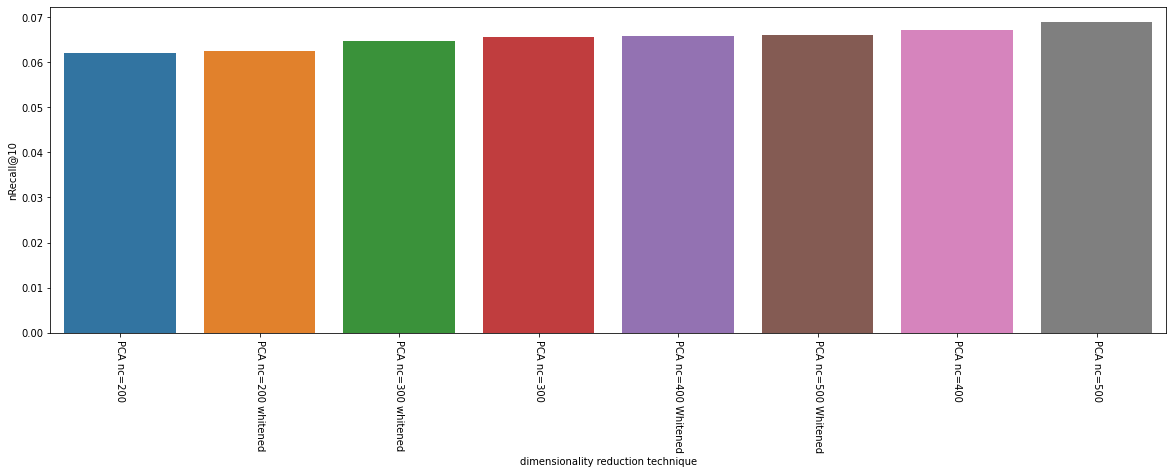

In [20]:
with open('./evaluation/v3/quantitative/ImprovedRec_PCA.pickle.gz', 'rb') as handle:
    labels = pickle.load(handle)
    
with open('./evaluation/v3/quantitative/ImprovedRec_PCA_results.pickle.gz', 'rb') as handle:
    results = pickle.load(handle)
    
labels = [str(label) for label in labels]
for key in results[0].keys():
    if key[-2:] == '10' and key[:-3] != 'ideal_recall':
        values = [average(result[key]) for result in results]
        visualize(labels, values, key, 'dimensionality reduction technique', width=20)

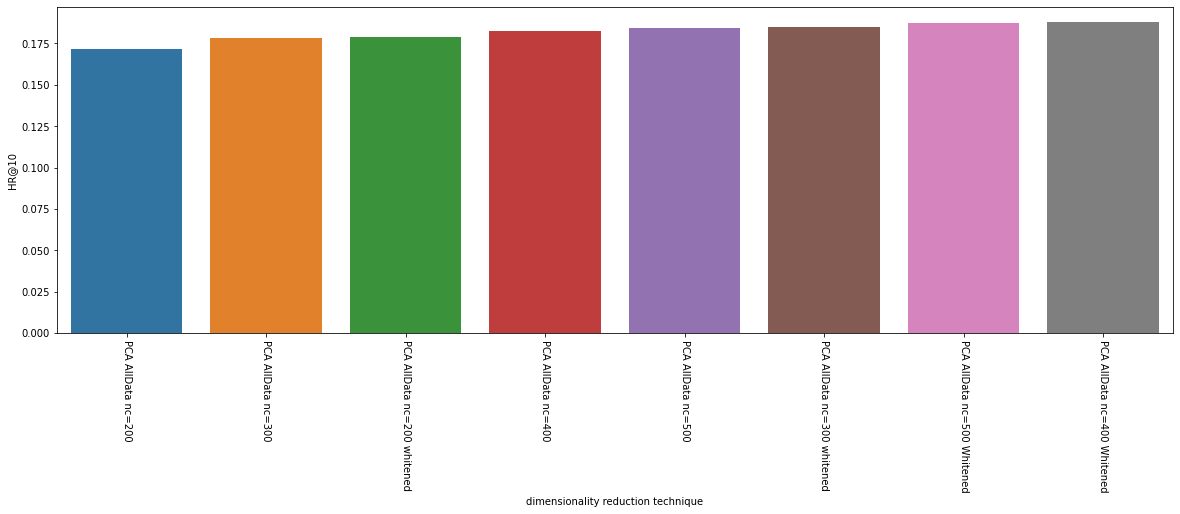

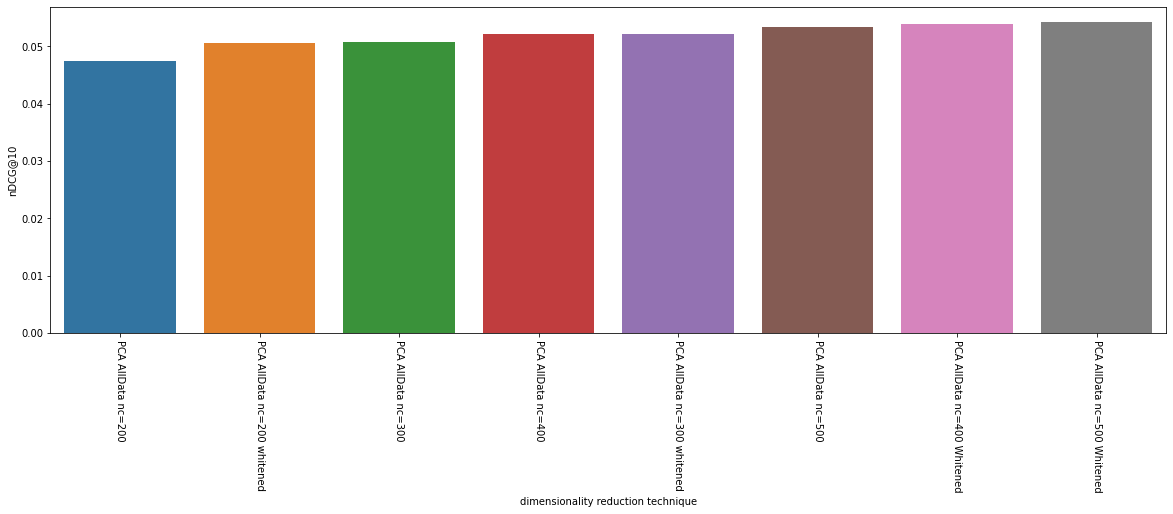

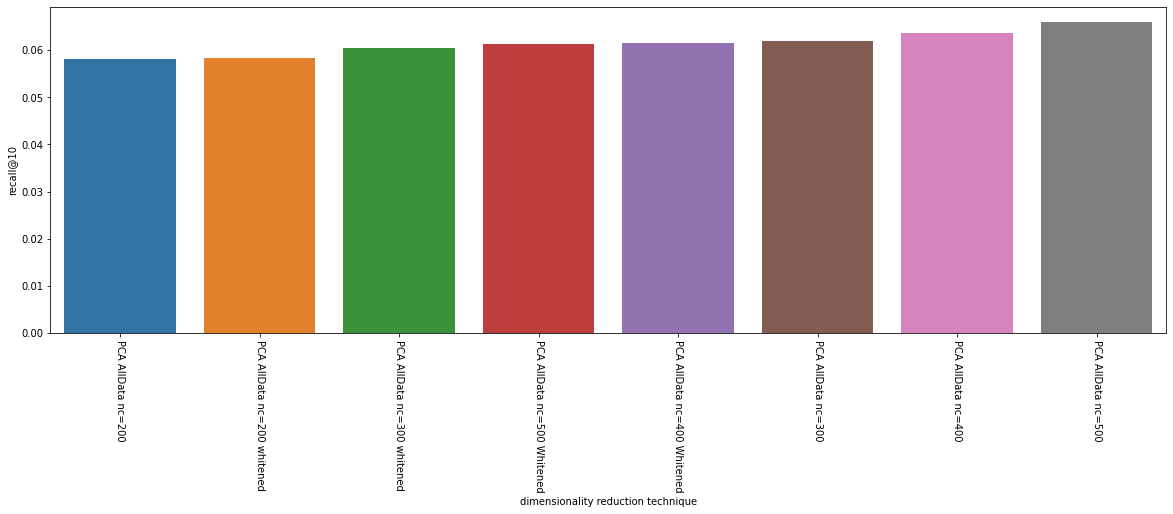

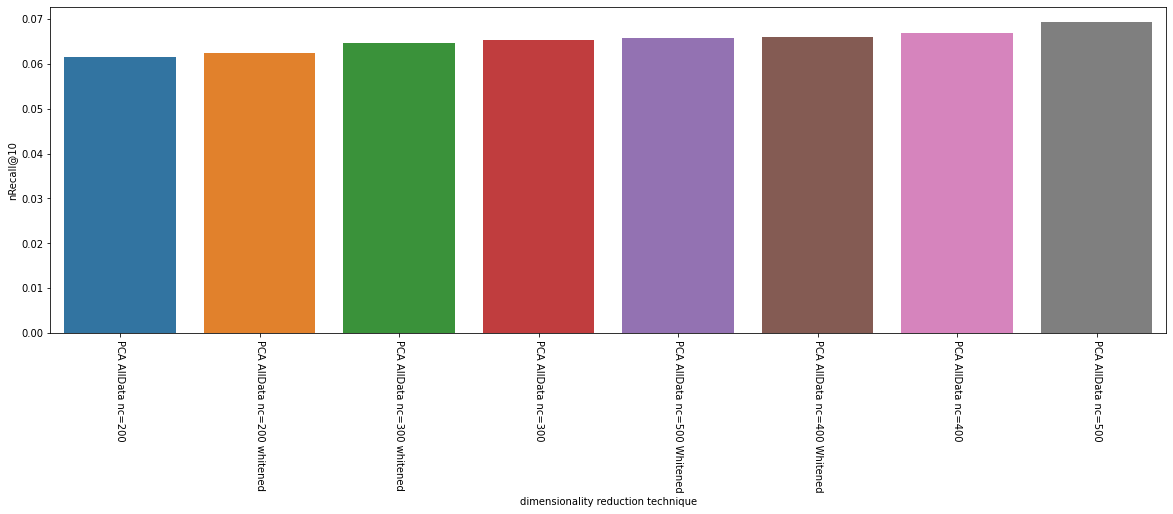

In [22]:
with open('./evaluation/v3/quantitative/ImprovedRec_PCA_alldata.pickle.gz', 'rb') as handle:
    labels = pickle.load(handle)
    
with open('./evaluation/v3/quantitative/ImprovedRec_PCA_alldata_results.pickle.gz', 'rb') as handle:
    results = pickle.load(handle)
    
labels = [str(label) for label in labels]
for key in results[0].keys():
    if key[-2:] == '10' and key[:-3] != 'ideal_recall':
        values = [average(result[key]) for result in results]
        visualize(labels, values, key, 'dimensionality reduction technique', width=20)

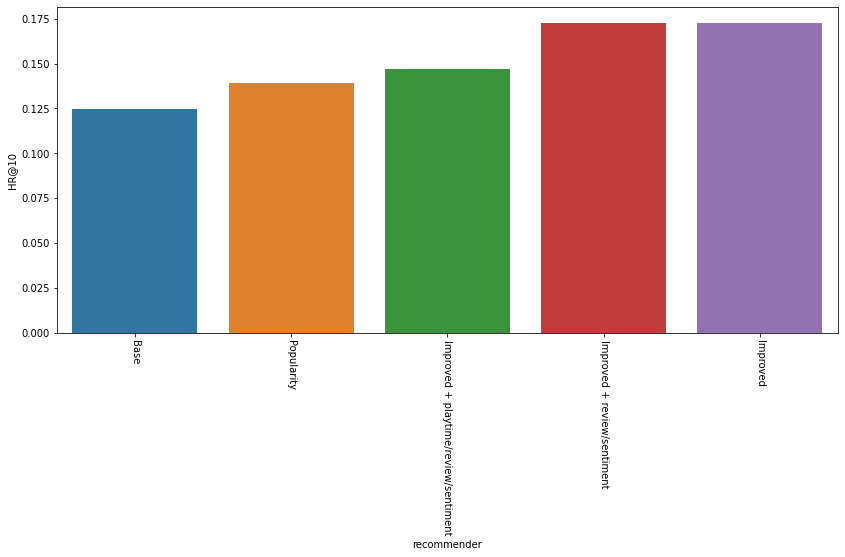

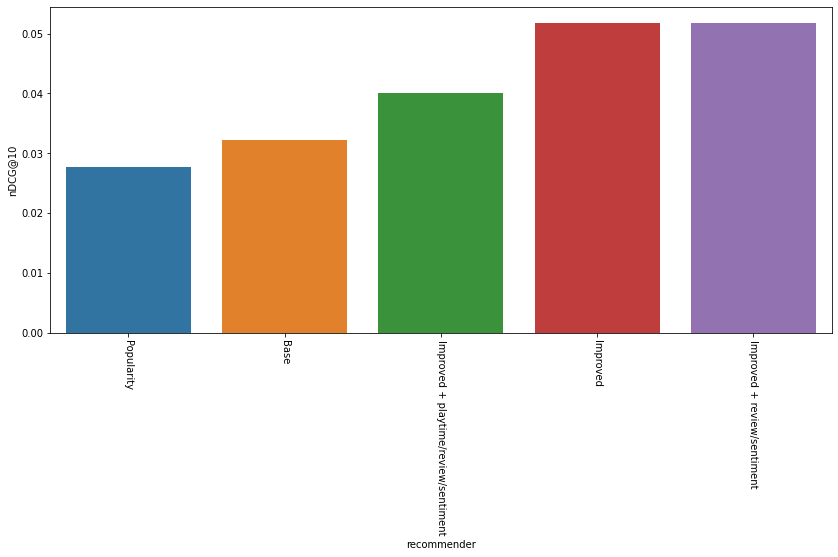

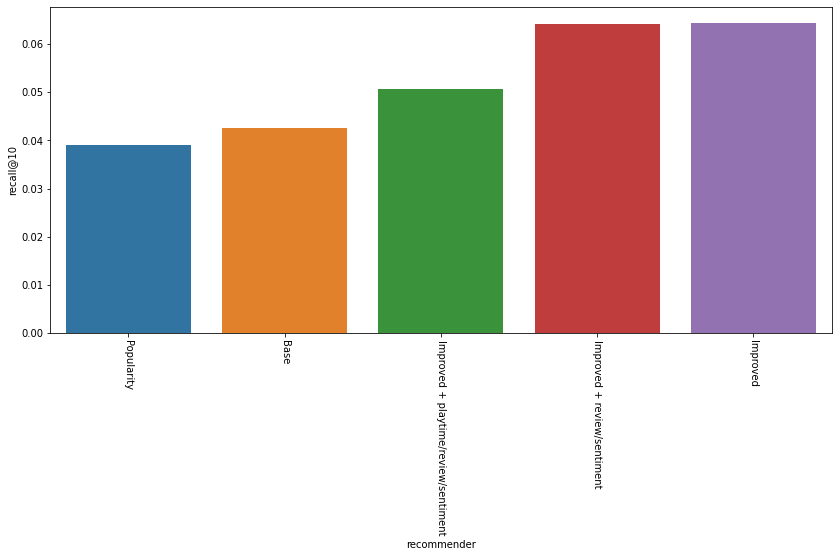

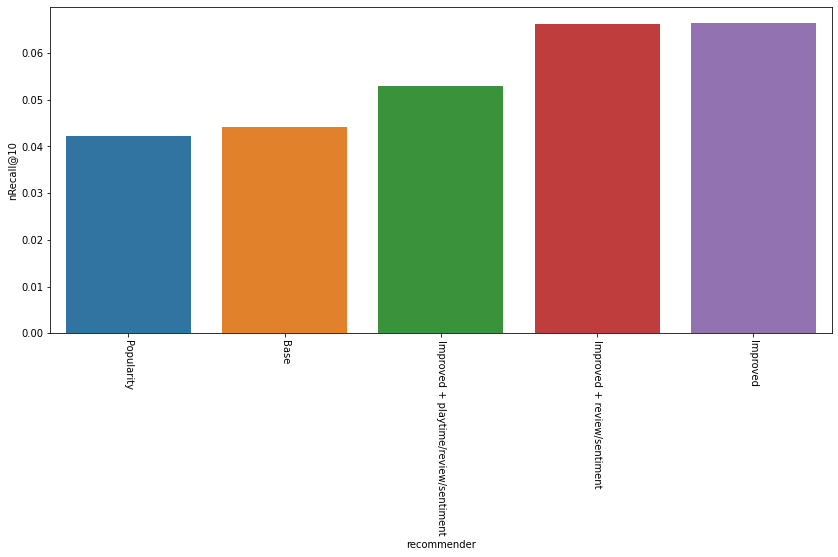

In [26]:
results = []
labels = ['PopBased', 'BaseRecommender', 'ImprovedRec_none', 'ImprovedRec_sentiment_onlyrating', 'ImprovedRec_allweighting_onlyrating']
actual_labels = ['Popularity', 'Base', 'Improved', 'Improved + review/sentiment', 'Improved + playtime/review/sentiment']

for label in labels:
    with open(f'./evaluation/v3/quantitative/{label}.pickle.gz', 'rb') as handle:
        results.append(pickle.load(handle))
    
for key in results[0].keys():
    if key[-2:] == '10' and key[:-3] != 'ideal_recall':
        values = [average(result[key]) for result in results]
        visualize(actual_labels, values, key, 'recommender', width=14)

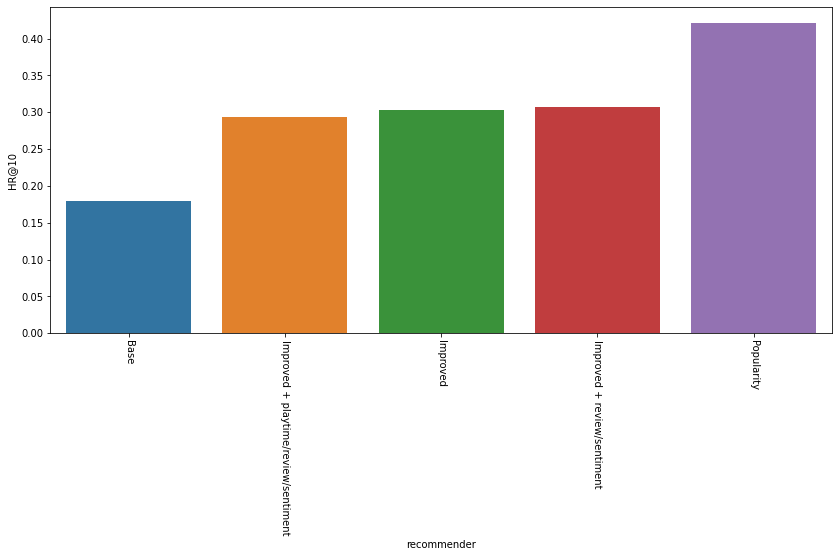

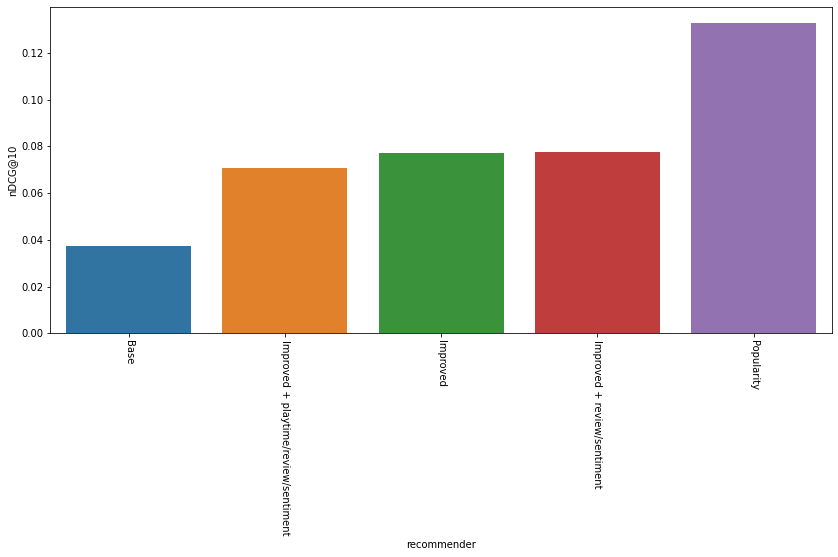

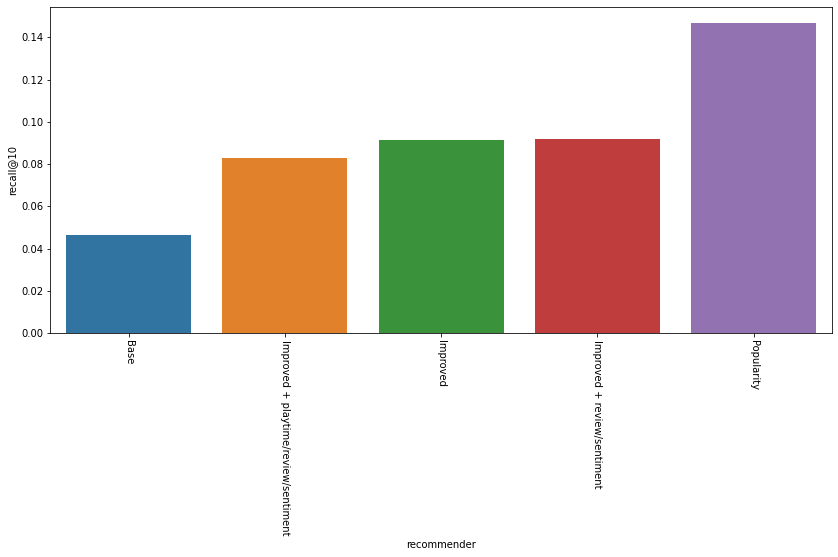

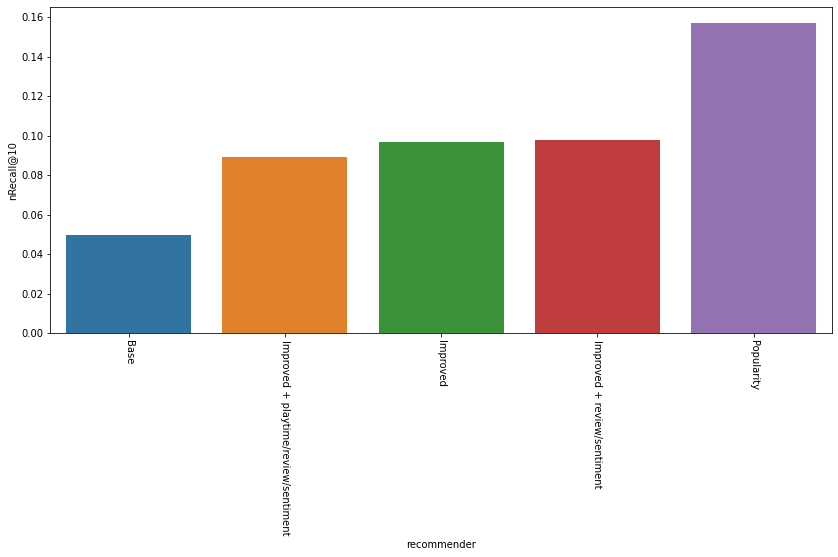

In [27]:
results = []
labels = ['PopBased', 'BaseRecommender', 'ImprovedRec_none', 'ImprovedRec_sentiment', 'ImprovedRec_allweighting']
actual_labels = ['Popularity', 'Base', 'Improved', 'Improved + review/sentiment', 'Improved + playtime/review/sentiment']

for label in labels:
    with open(f'./evaluation/v2/quantitative/{label}.pickle.gz', 'rb') as handle:
        results.append(pickle.load(handle))
    
for key in results[0].keys():
    if key[-2:] == '10' and key[:-3] != 'ideal_recall':
        values = [average(result[key]) for result in results]
        visualize(actual_labels, values, key, 'recommender', width=14)